In [9]:
%load_ext autoreload
%autoreload 2

import json
from itertools import chain

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

from biobank_olink.constants import PROJECT_ROOT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
results = [json.load(p.open()) for p in (PROJECT_ROOT / "results").iterdir()
           if p.name.startswith("cross_sectional")]
results = pd.DataFrame(chain.from_iterable(results))

group_cols = ["lifestyle", "ext", "olink", "panel"]
agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "best_trial_score", "num_trials", "best_trial_no", "n_estimators"]}
results.groupby(group_cols, dropna=False).agg(**agg_values, count=("model", 'size'))

mean_auc_score  mean_best_trial_score  \
lifestyle ext   olink panel                                                 
False     False False ALL                 0.664918               0.665221   
True      False False ALL                 0.696197               0.696867   
          True  False ALL                 0.722158               0.721680   
                True  ALL                 0.795339               0.793580   
                      BP                  0.761772               0.760060   
                      ENDOTHELIAL         0.739792               0.739149   
                      IMMUNE              0.756012               0.754855   
                      IMMUNE_INFL2        0.755177               0.755594   
                      INFL2               0.744146               0.742975   
                      RENAL               0.764207               0.762610   

                                    mean_num_trials  mean_best_trial_no  \
lifestyle ext   olink panel                                               
False     False False ALL                     156.0               130.4   
True      False False ALL                     157.0               120.2   
          True  False ALL                     157.0               113.6   
                True  ALL                     157.0               126.4   
                      BP                      157.0               131.4   
                      ENDOTHELIAL             157.0               107.8   
                      IMMUNE                  157.0               114.2   
                      IMMUNE_INFL2            157.0               128.2   
                      INFL2                   157.0               121.4   
                      RENAL                   157.0               134.8   

                                    mean_n_estimators  count  
lifestyle ext   olink panel                                   
False     False False ALL                      1192.6      5  
True      False False ALL                      3362.2      5  
          True  False ALL                      3508.2      5  
                True  ALL                      4373.2      5  
                      BP                       3842.4      5  
                      ENDOTHELIAL              4020.8      5  
                      IMMUNE                   4210.0      5  
                      IMMUNE_INFL2             4140.4      5  
                      INFL2                    4566.0      5  
                      RENAL                    4133.0      5

In [11]:
results_gb = results.groupby(group_cols, dropna=False, as_index=False)
results_aucs = results_gb.agg({"auc_score": "mean", "x_shape": lambda v: v.values[0][1]})
results_aucs["exp_case"] = "age+sex"
results_aucs["exp_case"] += results_aucs[group_cols[:-2]].apply(
    lambda row: "".join(f"+{v}" for v in row.index[row]), axis=1)
results_aucs["exp_case"] += results_aucs.panel.apply(lambda v: f"+{v}").where(results_aucs.olink,
                                                                              "").str.lower()
results_aucs = results_aucs.set_index(["exp_case", "x_shape"])[["auc_score"]]
results_aucs.sort_index(level=1, inplace=True)
results_aucs.index = [f"{name} ({num_col})" for name, num_col in results_aucs.index.to_flat_index()]
results_aucs.index.name = "exp_case"
results_aucs

,auc_score
exp_case,
age+sex (2),0.664918
age+sex+lifestyle (18),0.696197
age+sex+lifestyle+ext (35),0.722158
age+sex+lifestyle+ext+bp (219),0.761772
age+sex+lifestyle+ext+endothelial (237),0.739792
age+sex+lifestyle+ext+renal (348),0.764207
age+sex+lifestyle+ext+infl2 (539),0.744146
age+sex+lifestyle+ext+immune (924),0.756012
age+sex+lifestyle+ext+immune_infl2 (988),0.755177


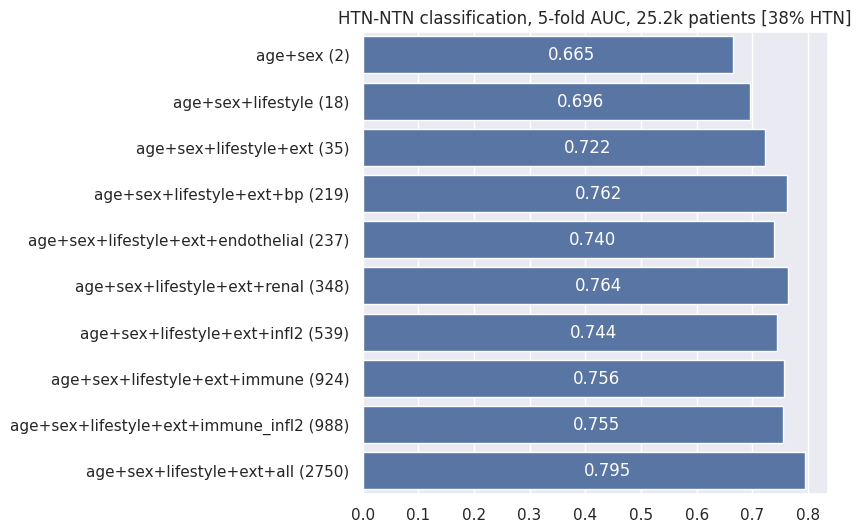

In [12]:
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=results_aucs.reset_index(), y="exp_case", x="auc_score")
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width / 2,
        p.get_y() + p.get_height() / 2,
        '{:.3f}'.format(width),
        va='center', color="white"
    )
plt.ylabel(None)
plt.xlabel(None)
plt.title("HTN-NTN classification, 5-fold AUC, 25.2k patients [38% HTN]")
plt.show()

## Dump future importances to the Excel spreadsheet

In [13]:
from biobank_olink.constants import PROJECT_DATA


def get_feature_importances(filename: str):
    df = pd.read_json(PROJECT_ROOT / "results" / filename)
    feat_imps = (
        pd.DataFrame.from_records(df.shap_importance)
        .rank(ascending=False, axis=1)
        .mean()
        .sort_values(ascending=True)
    ).reset_index()
    feat_imps.columns = pd.MultiIndex.from_product(
        [[df.study_name.iloc[0]], ["feature", "importance_rank"]])
    return feat_imps


file_names = [
    "cross_sectional_xgb_corr0.9_lifestyle_ext_olink.json",
    "prospective_xgb_corr0.9_y10_lifestyle_ext_olink.json",
    "prospective_xgb_corr0.9_y10_lifestyle_ext_sbp_olink.json",
]

feat_imps = pd.concat([get_feature_importances(fn) for fn in file_names], axis=1)
feat_imps.to_excel(PROJECT_DATA / "feature_importances.xlsx")
feat_imps

cross_sectional_xgb_corr0.9_lifestyle_ext_olink                  \
                                             feature importance_rank   
0                                                REN             1.4   
1                                                age             1.6   
2                                              ACTA2             3.4   
3                                              PTPRB             3.6   
4                                   GlucoseInstance0             6.2   
...                                              ...             ...   
2746                                          GLIPR1          2685.8   
2747                                     smoking_1.0          2685.8   
2748                                     alcohol_6.0          2685.8   
2749                                     alcohol_4.0          2685.8   
2750                                             NaN             NaN   

     prospective_xgb_corr0.9_y10_lifestyle_ext_olink                  \
                                             feature importance_rank   
0                                                age             1.0   
1                                                REN             2.2   
2                                              GDF15             3.0   
3                                             HAVCR1             4.0   
4                                                ADM             7.0   
...                                              ...             ...   
2746                                     alcohol_6.0          2632.3   
2747                                     alcohol_2.0          2644.7   
2748                                     alcohol_1.0          2649.1   
2749                                          GLIPR1          2649.6   
2750                                             NaN             NaN   

     prospective_xgb_corr0.9_y10_lifestyle_ext_sbp_olink                  
                                                 feature importance_rank  
0                                                   sbp              1.2  
1                                                   age              1.8  
2                                                   REN              3.2  
3                                                 GDF15              4.0  
4                                                HAVCR1              5.2  
...                                                 ...              ...  
2746                                        alcohol_6.0           2332.3  
2747                                              AP3B1           2332.3  
2748                                           MAPKAPK2           2332.3  
2749                                              ADH1B           2332.3  
2750                                              PIBF1           2332.3  

[2751 rows x 6 columns]